In [1]:
install.packages("rsample")
install.packages("h2o")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘h2o’ is not available (for R version 3.6.3)”


Employee attrition information originally provided by IBM Watson Analytics Lab.    
* problem type: supervised binomial classification
* response variable: Attrition (i.e., “Yes”, “No”)
* features: 30
* observations: 1,470
* objective: use employee attributes to predict if they will attrit (leave the company)
* access: provided by the rsample package (Kuhn and Wickham 2019)
* more details: See ?rsample::attrition


In [2]:
# Helper packages
library(dplyr)     # for data manipulation
library(ggplot2)   # for awesome graphics

# Modeling process packages
library(rsample)   # for resampling procedures
library(caret)     # for resampling and model training
library(h2o)       # for resampling and model training

# h2o set-up 
h2o.no_progress()  # turn off h2o progress bars
h2o.init()         # launch h2o


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: lattice


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit http://docs.h2o.ai

----------------------------------------------------------------------



Attaching package: ‘h2o’


The following objects are masked from ‘package:stats’:

    cor, sd, var


The following objects are masked from ‘package:base’:

    &&, %*%, %in%, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc




 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         22 hours 59 minutes 
    H2O cluster timezone:       America/Montevideo 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.30.1.2 
    H2O cluster version age:    24 days  
    H2O cluster name:           H2O_started_from_R_cesar_jro824 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   3.14 GB 
    H2O cluster total cores:    8 
    H2O cluster allowed cores:  8 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4 
    R Version:                  R version 3.6.3 (2020-02-29) 



In [3]:
data("attrition", package = "modeldata")
names(attrition)

[1] "Age"                      "Attrition"               
 [3] "BusinessTravel"           "DailyRate"               
 [5] "Department"               "DistanceFromHome"        
 [7] "Education"                "EducationField"          
 [9] "EnvironmentSatisfaction"  "Gender"                  
[11] "HourlyRate"               "JobInvolvement"          
[13] "JobLevel"                 "JobRole"                 
[15] "JobSatisfaction"          "MaritalStatus"           
[17] "MonthlyIncome"            "MonthlyRate"             
[19] "NumCompaniesWorked"       "OverTime"                
[21] "PercentSalaryHike"        "PerformanceRating"       
[23] "RelationshipSatisfaction" "StockOptionLevel"        
[25] "TotalWorkingYears"        "TrainingTimesLastYear"   
[27] "WorkLifeBalance"          "YearsAtCompany"          
[29] "YearsInCurrentRole"       "YearsSinceLastPromotion" 
[31] "YearsWithCurrManager"

In [4]:
# Job attrition data
churn <- attrition %>% 
  mutate_if(is.ordered, .funs = factor, ordered = FALSE)
churn.h2o <- as.h2o(churn)

In [5]:
# initial dimension
dim(attrition)
## [1] 1470   31

# response variable
head(attrition)


[1] 1470   31

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,⋯,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
,<int>,<fct>,<fct>,<int>,<fct>,<int>,<ord>,<fct>,<ord>,<fct>,⋯,<ord>,<ord>,<int>,<int>,<int>,<ord>,<int>,<int>,<int>,<int>
1,41,Yes,Travel_Rarely,1102,Sales,1,College,Life_Sciences,Medium,Female,⋯,Excellent,Low,0,8,0,Bad,6,4,0,5
2,49,No,Travel_Frequently,279,Research_Development,8,Below_College,Life_Sciences,High,Male,⋯,Outstanding,Very_High,1,10,3,Better,10,7,1,7
4,37,Yes,Travel_Rarely,1373,Research_Development,2,College,Other,Very_High,Male,⋯,Excellent,Medium,0,7,3,Better,0,0,0,0
5,33,No,Travel_Frequently,1392,Research_Development,3,Master,Life_Sciences,Very_High,Female,⋯,Excellent,High,0,8,3,Better,8,7,3,0
7,27,No,Travel_Rarely,591,Research_Development,2,Below_College,Medical,Low,Male,⋯,Excellent,Very_High,1,6,3,Better,2,2,2,2
8,32,No,Travel_Frequently,1005,Research_Development,2,College,Life_Sciences,Very_High,Male,⋯,Excellent,High,0,8,2,Good,7,7,3,6


## Splittin dataset

In [7]:
# Using base R
set.seed(123)  # for reproducibility
index_1 <- sample(1:nrow(churn), round(nrow(churn) * 0.7))
train_1 <- churn[index_1, ]
test_1  <- churn[-index_1, ]

# Using caret package
set.seed(123)  # for reproducibility
index_2 <- createDataPartition(churn$Attrition, p = 0.7, 
                               list = FALSE)
train_2 <- churn[index_2, ]
test_2  <- churn[-index_2, ]

# Using rsample package
set.seed(123)  # for reproducibility
split_1  <- initial_split(churn, prop = 0.7)
train_3  <- training(split_1)
test_3   <- testing(split_1)

# Using h2o package
split_2 <- h2o.splitFrame(churn.h2o, ratios = 0.7, 
                          seed = 123)
train_4 <- split_2[[1]]
test_4  <- split_2[[2]]

# EDA

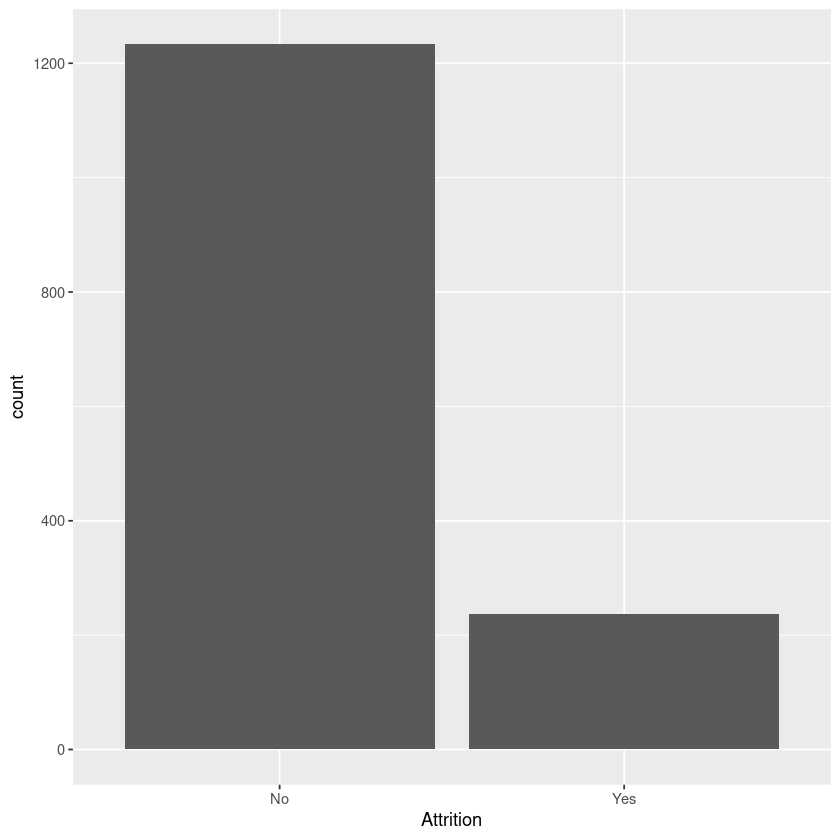

In [8]:
ggplot(attrition, aes(x=Attrition)) + geom_bar()

# Modeling
R tiene un aplio abanico de librerias que implementan diferentes tipos de modelos e incluso varias implementaciones del mismo modelo pero con diferentes enfoques. Ademas de estos hay librerias que unifican estas para agilizar el proceso de modelo y standarizar los procesos.

Hay diferentes formas de como se deben pasar la data para entrenar un modelo:
* Clasica de R usando una formula como una expresion sombolica de la relacion de dependencia 
    * `fn(Y ~ X)`
* usando separadamente $Y$, $X$ como argumentos independientes
    * `fn(x = ames[, features], y = ames$Sale_Price)`
* usando separadamente $Y$, $X$ pero pasando solo el nombre de las variables de un dataframe 
    * `fn(x = c("Year_Sold", "Longitude", "Latitude"), y = "Sale_Price", data = ames.h2o)`



## Engines
Como se mencion anteriormente hay varias librerias que implementan por ejemplo el mismo modelo pero con diferente sabpres, estos son conocidos como "engines"

In [13]:
lm_glm <- glm(Attrition ~ ., data = train_2, binomial(link="logit"))
summary(lm_glm)


Call:
glm(formula = Attrition ~ ., family = binomial(link = "logit"), 
    data = train_2)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0136  -0.4719  -0.2311  -0.0617   3.6539  

Coefficients:
                                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)                       -1.533e+01  1.412e+03  -0.011 0.991340    
Age                               -2.252e-02  1.703e-02  -1.323 0.185960    
BusinessTravelTravel_Frequently    2.696e+00  5.788e-01   4.657 3.21e-06 ***
BusinessTravelTravel_Rarely        1.764e+00  5.383e-01   3.276 0.001053 ** 
DailyRate                         -1.600e-04  2.738e-04  -0.584 0.558992    
DepartmentResearch_Development     1.492e+01  1.412e+03   0.011 0.991574    
DepartmentSales                    3.163e-02  1.592e+03   0.000 0.999984    
DistanceFromHome                   5.494e-02  1.346e-02   4.081 4.48e-05 ***
EducationCollege                   2.020e-01  4.069e-01   0.496 0.619564    
Education

In [17]:
lm_caret  <- train(Attrition ~ ., data = train_2,   method = "rf", family = "binomial")

In [18]:
lm_caret

Random Forest 

1030 samples
  30 predictor
   2 classes: 'No', 'Yes' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1030, 1030, 1030, 1030, 1030, 1030, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   2    0.8475894  0.0831858
  29    0.8525177  0.2370729
  57    0.8459769  0.2319998

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 29.

In [16]:
pred = predict(lm_caret, newdata = test_2)
table(pred, test_2$Attrition)


     
pred   No Yes
  No  352  37
  Yes  17  34

In [77]:
pred = predict(lm_caret, newdata = test_2, type = "prob")

In [78]:
head(pred)

,No,Yes
,<dbl>,<dbl>
1,0.780,0.220
2,0.904,0.096
5,0.876,0.124
6,0.904,0.096
9,0.822,0.178
14,0.840,0.160


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



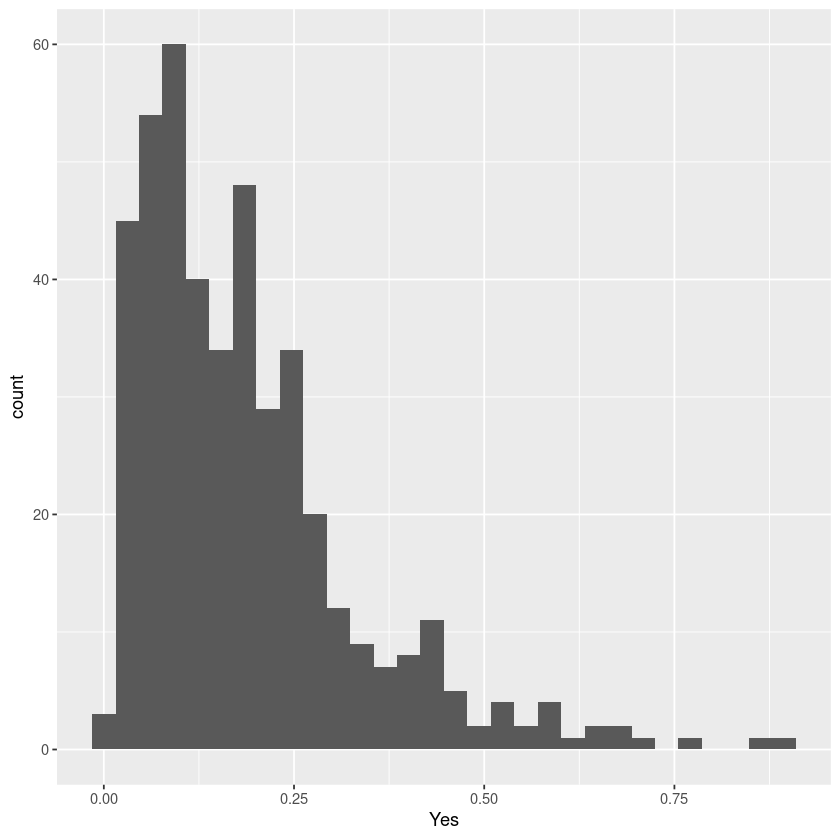

In [79]:
ggplot(pred, aes(Yes) ) + geom_histogram()

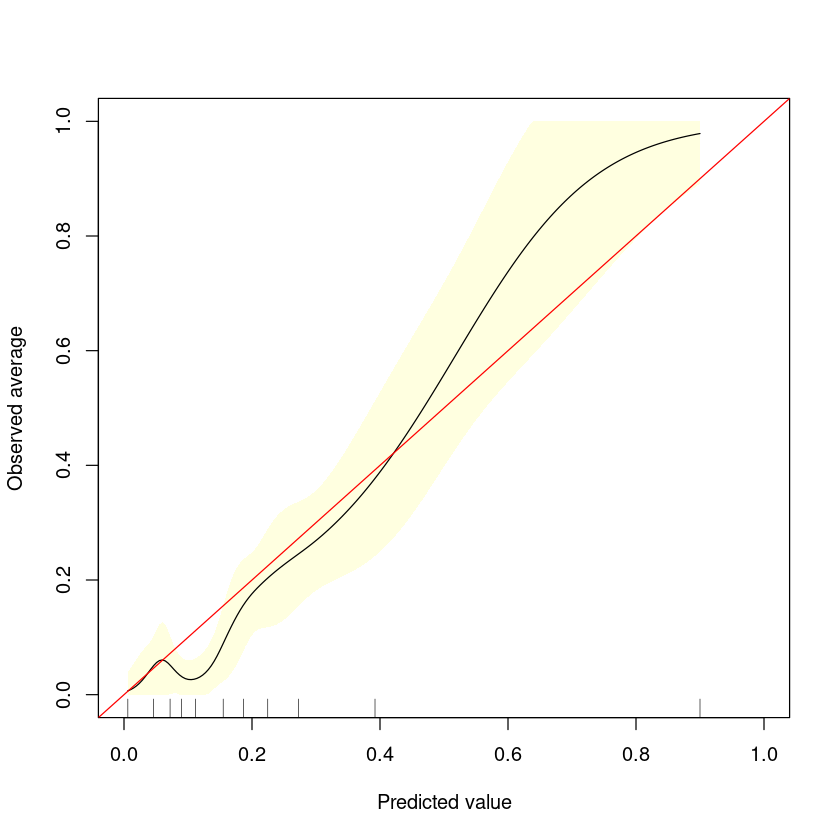

In [80]:
y = as.numeric(test_2$Attrition) - 1 
calibrate.plot(y, pred$Yes, )


In [61]:
install.packages("gbm")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [62]:
library(gbm)

Loaded gbm 2.1.8

